In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from keras.optimizers import Adam
import glob
import os
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

ModuleNotFoundError: No module named 'torch'

In [5]:
path = pathlib.Path("/kaggle/input/ricedata/Rice_Image_Dataset")

In [6]:
arborio = list(path.glob('Arborio/*'))
basmati = list(path.glob('Basmati/*'))
ipsala = list(path.glob('Ipsala/*'))
jasmine = list(path.glob('Jasmine/*'))
karacadag = list(path.glob('Karacadag/*'))

total_list=arborio + basmati + ipsala + jasmine + karacadag

In [7]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

model_dataset = datasets.ImageFolder(path, transform=data_transform) 
# 이미지 폴더 읽어서 데이터셋 만듬 

image, label = model_dataset[0] # 이미지 라벨 분류
print(f"Image Size: {image.shape}") # 이미지 형태 
print(f"Label: {label}") # 라벨 형태 
print(image)

Image Size: torch.Size([3, 250, 250])
Label: 0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [9]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((100,100)), # 사이즈 줄임 
        torchvision.transforms.RandomHorizontalFlip(), # 랜덤으로 각도 조정 
        torchvision.transforms.ToTensor(), # 아마자 tensor로 변환 
        torchvision.transforms.Normalize(  # normalize 
            mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
        ),
    ]
)
BATCH_SIZE=256

# 데이터셋을 읽어서 train valid test로 나눈다
model_dataset = datasets.ImageFolder(path, transform=data_transform) 
train_count = int(0.7 * len(total_list)) 
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))

# 나눈 데이터셋을 불러온다
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

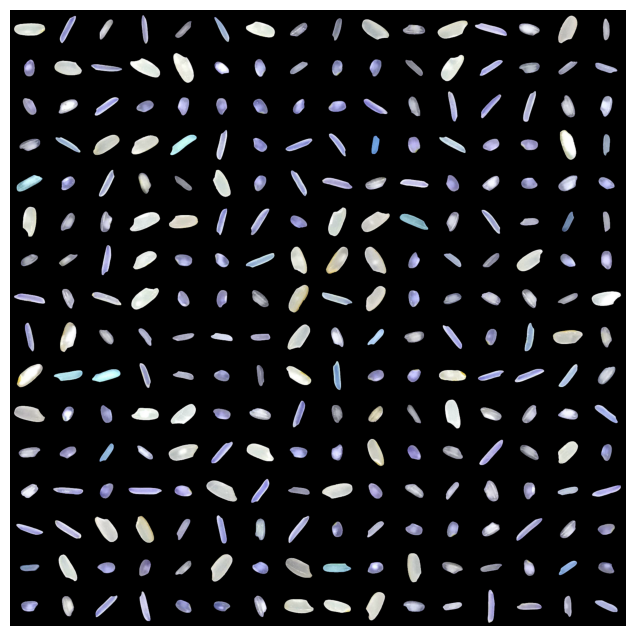

In [10]:
for item in train_dataset_loader: # train_loader에서 데이터를 불러와서 
    plt.figure(figsize=(16,8))
    image,_=item     # image , _ 로 나눠
    plt.imshow(make_grid(image,nrow=16).permute(1,2,0)) # 100,100,3으로 바꾸려고 permute 수행
    plt.axis('off')
    plt.show()
    break

In [11]:
image.shape

torch.Size([256, 3, 100, 100])

In [12]:
_.shape

torch.Size([256])

## Model 생성

In [28]:
class CustomizedConvNet(nn.Module):
    def __init__(self,number_of_classes):
        super().__init__() #Inheritance
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,padding=1,kernel_size=3)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,padding=1,kernel_size=3)
        self.bn2=nn.BatchNorm2d(num_features=20)
        self.relu2=nn.ReLU()
        # 2번째 layer에서는 pooling 을 진행하지 않음 
        
        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,padding=1,kernel_size=3)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        

        self.fc1=nn.Linear(32*25*25, 5)
        # 왜 25*25인지 모르겠음 

    
    def forward(self, Input):
        
        output=self.conv1(Input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)
        
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=self.pool3(output)
        output = torch.flatten(output, 1) # 차원을 펴줌 
        
        output = output.view(-1,32*25*25) # fc1에 넣을수있도록 형태를 변경 
        output=self.fc1(output)

        
        return output

In [29]:
model = CustomizedConvNet(5)
device='cuda'
model = model.to(device)
model

CustomizedConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=5, bias=True)
)

In [ ]:
torchinfo.summary(model,[256,3,100,100])

## Training the model

In [32]:
def accuracy(pred,label): #정확도 함수 
    _,out = torch.max(pred,dim=1)
    return torch.tensor(torch.sum(out==label).item()/len(pred))

def validation_step(valid_dl,model,loss_fn): # 평가
    for image,label in valid_dl:   # 입력받은 valid_dl
        out = model(image)         # model 에 넣음
        loss = loss_fn(out,label)  # loss출력
        acc = accuracy(out,label)  # accuaray 출력
        return {'val_loss':loss , 'val_acc':acc}
    
def fit_to_model(train_dl,valid_dl,epochs,optimizer,loss_fn,model): # train 모델에 훈련 
    history = []
    for epoch in range(epochs):
        for image , label in train_dl:
            out = model(image)
            loss = loss_fn(out , label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        val = validation_step(valid_dl, model, loss_fn)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss, "val_loss": val['val_loss'], "val_acc": val['val_acc']})
        # 빈 리스트에 loss , val_loss , val_acc 추가 
    
    return history

def to_device(data, device):
    if isinstance(data, (list, tuple)):   
        return [to_device(x, device) for x in data] # 데이터 device 적용시킴 
    return data.to(device, non_blocking=True) 

class DeviceDataLoader(): # 가장 먼저 dataloader를 적용시킴
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,self.device)


In [33]:
# device 적용 시킴
train_dataset_loader = DeviceDataLoader(train_dataset_loader,device)
valid_dataset_loader = DeviceDataLoader(valid_dataset_loader,device)

In [34]:
# 하이퍼 파라미터 설정하고 model에 적합시키는 부분 
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 5
history = fit_to_model(train_dataset_loader,valid_dataset_loader,epochs,optimizer,Loss,model)

Epoch [0/5] => loss: 0.036218367516994476, val_loss: 0.04615720734000206, val_acc: 0.984375
Epoch [1/5] => loss: 0.005231004673987627, val_loss: 0.0373118557035923, val_acc: 0.98828125
Epoch [2/5] => loss: 0.041034407913684845, val_loss: 0.02890973724424839, val_acc: 0.98828125
Epoch [3/5] => loss: 0.014538893476128578, val_loss: 0.035589076578617096, val_acc: 0.99609375
Epoch [4/5] => loss: 0.001115742838010192, val_loss: 0.003864519065245986, val_acc: 1.0


## model test

In [35]:
model = model.cpu()
with torchno_grad():
    
    for img,label in test_dataset_loader:
        imgs = img[10]
        labels = label[10]
        output_model = imgs.unsqueeze(0) # img차원을 늘림 
        output_model = model(output_model) # 모델에 넣음 
        index = output_model.argmax()    
        imgs = torch.permute(imgs,(1,2,0)) #그림 그리기 위해 
        plt.imshow(imgs)
        plt.title(f'predicted:{model_dataset.classes[index]}\n real:{model_dataset_classes[labels]}')
        break

SyntaxError: invalid syntax (3789088338.py, line 4)